# Analysis of APT data (statistical distributions)

**System**
* Alloy stoichiometry (ideal): $Al_{0.1}FeNiCrCo$
* Lattice: FCC
* Lattice constant: 3.57A

**APT measurement**
* Detector efficiency: 33%
* position uncertainty (standard deviation): 5A (in x-, y-directions) and 3A in z-direction

## Setup

In [3]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

In [4]:
# basic libraries

import os, sys
import re
import copy
import glob
from itertools import product
import pickle
from collections import Counter
import numpy as np
#import scipy.io
from scipy.stats import multinomial, binom, chi2
from scipy.optimize import fmin
from sklearn.neighbors import NearestNeighbors

# plotting
import matplotlib.pyplot as plt

# data handling
# import pyUSID as usid
# import h5py
# import pandas as pd
# import xarray as xr

# parallelization
# from subprocess import Popen, PIPE
import multiprocessing as mp

In [5]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_mc, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt, cfg_replicate
from statmechlib.forcefields import sd2

In [6]:
# project directories
data_raw = '../data/interim'
src_dir = '../src/utils'
sim_dir = '../sim/enth_model'
sim_dir_m1 = '../sim/m1'
sim_dir_m2 = '../sim/m2'

In [7]:
sys.path.append(src_dir)
from utils import *

## Spatial statistics - XY profiles

In [22]:
data_id = ['0', '1', '2', '3', '4', 'Total', 'Noise']

data = {}
for dat in data_id:
    data[dat] = np.loadtxt(os.path.join(data_raw, f'RamaTest_CleanXYDist{dat}'))

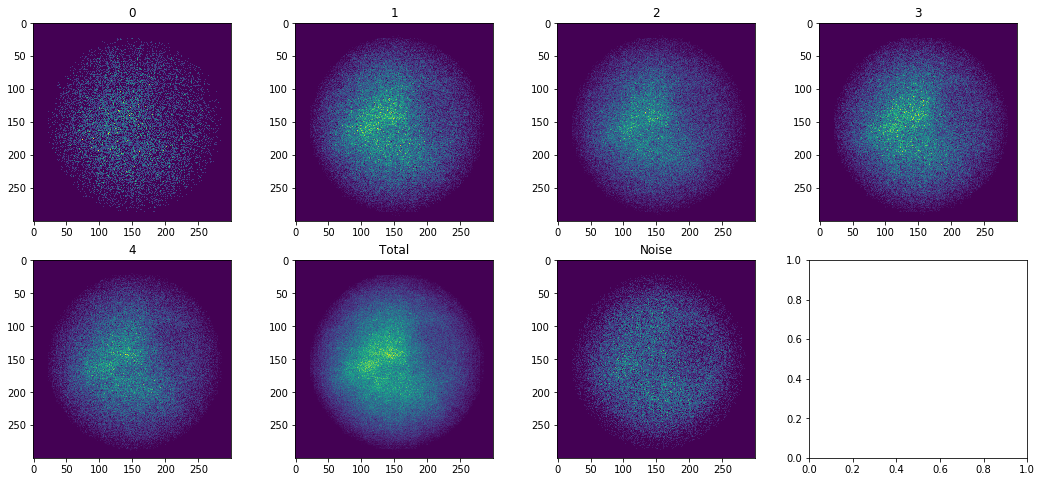

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axs = axs.ravel()
for i, dat in enumerate(data_id):
    axs[i].imshow(data[dat])
    axs[i].set_title(dat)

**Calculate density distributions**

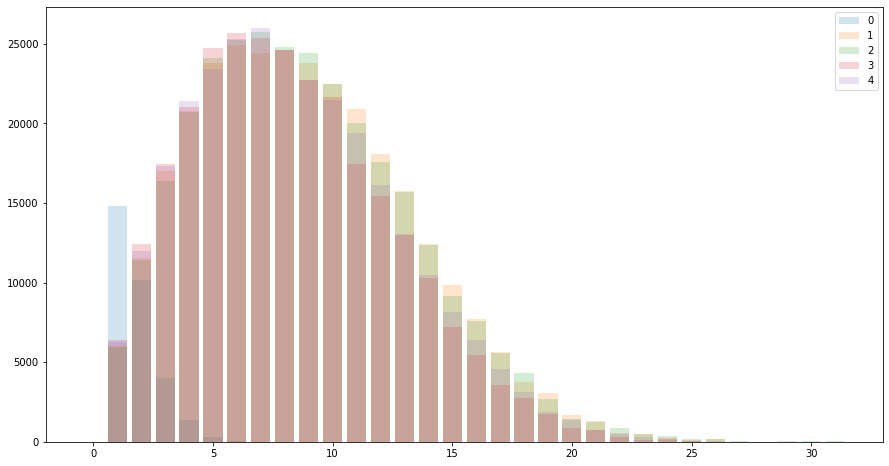

In [78]:
plt.figure(figsize=(15,8))

for dat in data_id[0:-2]:
    data_count = np.int_(data[dat].flatten())
    bincnt = np.bincount(data_count)
    #print(bincnt, len(bincnt), np.max(data[dat]))
    dens_cnt = np.array([i*v for i, v in enumerate(bincnt)])
    #print(dens_cnt)
    plt.bar(list(range(len(dens_cnt))), dens_cnt, alpha=0.2, label=dat)
    
plt.legend()

## Read KNN statistics

In [11]:
# compositions, concentrations, atom types
element = ['Al','Fe','Ni','Cr','Co']
ntype = len(element)

# numbers of KNNs of a particular atom i of type ti
knn = list(range(1,13))
#knn += [20, 40, 100, 200, 500, 1000]

In [12]:
# functions to read data files with pairwise statistics

def read_pairwise(file_name, nn, ntype):
    """
    Parameters
    ----------
    file_name: str
        Input file with pairwise statistics
    nn: int
        number of nearest neighbors
    ntype: number of atom types
    
    Returns
    -------
    stats: ndarray(ntype, ntype, nn)
        all pairwise statistics for all atom types
    """
    
    # output array
    stats = np.zeros((ntype, ntype, nn+1), dtype=int)
    
    # regex to extract particle types
    atom_info = re.compile(r'IonType\s*(\d+)\s*,\s*type\s*(\d+)\s+')
    
    with open(file_name, 'r') as fin:
        for line in iter(fin.readline, ''):
            m = atom_info.search(line)
            i, j = [int(c) for c in m.groups()]

            counts = re.findall('\d+', fin.readline())
            stats[i, j, :] = [int(c) for c in counts]

    return stats

In [13]:
targets = {}
for k in knn:
    targets[k] = read_pairwise(os.path.join(data_raw, f'RamaTest_Clean_PatternK{k}_PairWise'), k, ntype)

In [20]:
targets[12].shape

(5, 5, 13)

In [42]:
# count statistics and concentrations
counts = np.sum(targets[knn[5]], axis=2)[:,0]
assert np.array_equal(counts, np.sum(targets[knn[0]], axis=2)[:,0])

conc = counts/np.sum(counts)

tot_counts = np.sum(counts)

In [43]:
tot_counts, counts, conc

(1200233,
 array([ 30699, 300950, 300909, 280969, 286706]),
 array([0.02557753, 0.25074298, 0.25070882, 0.23409538, 0.23887529]))

In [50]:
# same counts from 2D profiles
[int(np.sum(data[dat])) for dat in data_id]

[30699, 300950, 300909, 280969, 286706, 1200233, 120556]

## Generate random distributions (null hypothesis)

* Assume that there are no interactioins between particles and for each KNN generate multinomial distributions with parameters (probabilities) set to mole fractions.

In [44]:
def get_binomials(k, probs):

    probs_null = np.zeros((ntype, ntype, k+1), dtype=float)

    # marginal distributions for selected atoms (equivalent to binomial distributions)
    for it in range(ntype):
        for jt in range(ntype):
            bn = binom(n=k, p=probs[jt])
            pmf_bn = probs[it]*bn.pmf(range(k+1))
            probs_null[it, jt, :] = pmf_bn
            #print(k, it, jt, pmf_bn)

    return probs_null

In [45]:
null_reference = {}
null_counts = {}
for k in knn:
    null_reference[k] = get_binomials(k, conc)
    null_counts[k] = null_reference[k]*tot_counts

## Convolute simulation data

In [46]:
def latt_to_real_coords(trj, scale=1.0):

    """
    Read xyz file with lattice coordinates
    and return rescaled atomic configurations in real units and (orthogonal) box dimensions.
    """
    
    boxs = []
    xyzs = []
    for box, xyz in zip(trj['box_latt'], trj['xyz_latt']):
        boxs.append(box*scale)
        xyzs.append(xyz*scale)
        # scale to fractional coordinates
        xyzs[-1] /= np.diag(boxs[-1])
    trj['box'] = boxs
    trj['xyz'] = xyzs
    return trj

In [70]:
def add_experimental_noise(trj, loss_rate=0.0, disp=[0.0, 0.0, 0.0], unknown_frac=0.0):
    """
    Apply random noise emulating APT experiment.
    Includes detector efficiency (only 33% retained) and random displacement.
    
    Parameters
    ----------
    xyz_in: list of ndarrays
        list of atom coordinates
    box: ndarray (3x3)
        box dimensions
    loss_rate: float or list of floats
        loss rate, overall (float) or per atom type (list)
    disp: array-like, shape(3)
        random displacement of atoms in x, y, z directions
        standard deviation of a Gaussian distribution
        
    Returns
    -------
    config_out: ndarray
        list of atoms and their coordinates in xyz format (type, x)
    """    
    
    xyzs = trj['xyz']
    boxs = trj['box']
    typs = trj['atom_type']

    xyzs_mod = []
    typs_mod = []

    for xyz, box, typ in zip(xyzs, boxs, typs):
        
        boxv = np.diag(box)

        xyz_mod = []
        typ_mod = []
        
        for r, t in zip(xyz, typ):
        
            # Step 1: remove a given fraction of particles
            if np.random.random() < loss_rate:
                continue
            
            # Step 2: displace atoms using Gaussian noise
            rr = boxv*r
            rr += np.array([np.random.normal(loc=0.0, scale=disp[i]) for i in range(3)])

            # adjust positions using periodic boundary conditions
            rr = np.where(rr < 0.0, rr+boxv, rr)
            rr = np.where(rr > boxv, rr-boxv, rr)
            
            rr /= boxv
                
            xyz_mod.append(rr)
            
            # unknown type (type==6)
            if np.random.random() < unknown_frac:
                typ_mod.append(6)
            else:
                typ_mod.append(t)

                
        xyzs_mod.append(np.array(xyz_mod))
        typs_mod.append(np.array(typ_mod))


    return xyzs_mod, typs_mod

In [71]:
def real_coords(xyzs, boxs):
    xyzs_mod = []
    for xyz, box in zip(xyzs, boxs):
        boxv = np.diag(box)
        xyzs_mod.append(xyz*boxv)

    return xyzs_mod

In [122]:
def select_core(xyzs, boxs, tis):
    """
    Selects the central (core) region of a configuration with all coordinates
    closer to the center than surface.
    """
    
    xyzs_core = []    
    tis_core = []
    for xyz, box, ti in zip(xyzs, boxs, tis):

        bv = np.diag(box)
    
        r_core = []
        t_core = []
        for r, t in zip(xyz, ti):
            if r[0]<0.25*bv[0] or r[1]<0.25*bv[1] or r[2]<0.25*bv[2]:
                continue
            if r[0]>=0.75*bv[0] or r[1]>=0.75*bv[1] or r[2]>=0.75*bv[2]:
                continue

            r_core.append(r)
            t_core.append(t)
            
        xyzs_core.append(np.array(r_core))
        tis_core.append(np.array(t_core))

    return xyzs_core, tis_core

In [298]:
# read in a set of trajectories
#trj_dirs = ['txinf', 'tx500', 'tx700', 'tx1000']
#trj_dirs = ['txinf']
trj_dirs = ['1x700']

In [299]:
#trjs = {}
for key in trj_dirs:
    # read trajectory info
    trjs[key] = read_lattice_mc(os.path.join(sim_dir_m1, key), verbose=1)

Reading ../sim/m1/1x700/lg.hst
Reading ../sim/m1/1x700/lg.run
Reading ../sim/m1/1x700/lg.xyz


## Add experimental noise

In [300]:
unknown_frac = counts[-1]/np.sum(counts)

# analyze configurations
for key, trj in trjs.items():
    if key not in ['1x700']:
        continue
    print('trj:', key)

    # convert from lattice to real coordinates
    trj = latt_to_real_coords(trj, 3.57/2.0)

    # model of experimental noise
    xyzs, typs = add_experimental_noise(trj, loss_rate=0.67, disp=np.array([5.0, 5.0, 3.0]), unknown_frac=unknown_frac)
    #xyzs, typs = add_experimental_noise(trj, loss_rate=0.0, disp=np.array([0.0, 0.0, 0.0]), unknown_frac=unknown_frac)
    trjs[key]['xyz_noise'] = xyzs
    trjs[key]['atom_type_noise'] = typs

trj: 1x700


In [301]:
[(k, v[0:5]) for k, v in trjs['tx500'].items()]

[('energy',
  [-3194.15999999987,
   -3535.539999999807,
   -3575.9599999998204,
   -3495.1399999997266,
   -3517.5499999997555]),
 ('interaction_stats',
  [[4, 105, 109, 103, 95, 515, 1022, 990, 981, 508, 957, 1024, 440, 922, 457],
   [2, 98, 130, 44, 144, 483, 1119, 974, 971, 464, 965, 986, 475, 919, 458],
   [1, 84, 155, 49, 130, 481, 1123, 954, 1005, 461, 929, 999, 494, 932, 435],
   [3, 94, 161, 57, 102, 491, 1108, 942, 1002, 461, 952, 985, 489, 923, 462],
   [3,
    93,
    143,
    50,
    128,
    487,
    1089,
    950,
    1022,
    476,
    1002,
    942,
    458,
    934,
    455]]),
 ('temp', [0.0, 500.0, 500.0, 500.0, 500.0]),
 ('box_latt', [array([[14,  0,  0],
          [ 0, 14,  0],
          [ 0,  0, 14]]), array([[14,  0,  0],
          [ 0, 14,  0],
          [ 0,  0, 14]]), array([[14,  0,  0],
          [ 0, 14,  0],
          [ 0,  0, 14]]), array([[14,  0,  0],
          [ 0, 14,  0],
          [ 0,  0, 14]]), array([[14,  0,  0],
          [ 0, 14,  0],
       

In [302]:
# 1. replicate configurations to avoid dealing with periodic boundary conditions
# 2. convert to real coordinates
# 3. select core
for key, trj in trjs.items():
    if key not in ['1x700']:
        continue

    print('trj:', key)
    xyzs = []
    boxs = []
    tis = []
    for xyz, box, ti in zip(trj['xyz_noise'], trj['box'], trj['atom_type_noise']):
        xyz_big, box_big = cfg_replicate(xyz, box, vec_a=2, vec_b=2, vec_c=2)
        xyzs.append(xyz_big)
        boxs.append(box_big)
        tis.append(np.tile(ti, 2*2*2))                                          

    trj['xyz_noise'] = xyzs
    trj['box_noise'] = boxs
    trj['atom_type_noise'] = tis
    
    trj['xyz_noise'] = real_coords(trj['xyz_noise'], trj['box_noise'])
    
    trj['xyz_core'], trj['atom_type_core'] = select_core(trj['xyz_noise'], trj['box_noise'], trj['atom_type_noise'])

trj: 1x700


In [303]:
# with open('../data/working/trjs.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

### Neighbor statistics

In [304]:
knns = list(range(1,13))
knns += [20, 40, 100, 200]

# 3. create nighbor model with the maximum of nearest neighbors (1000). KDTree should make this Nlog(N)
neigh = NearestNeighbors(n_neighbors=knns[-1], algorithm='kd_tree', n_jobs=4)

In [305]:
#neigh.fit(trjs['txinf']['xyz_noise'][0])

In [306]:
#get_stats = get_knn_stats(ind, ti, knns=knns)

In [307]:
Counter(trjs['tx700']['atom_type_core'][1]), Counter(trjs['tx700']['atom_type_noise'][1]), len(trjs['tx700']['atom_type_core'][1])*8, len(trjs['tx700']['atom_type_noise'][1])

(Counter({5: 92, 4: 90, 3: 104, 2: 102, 6: 44, 1: 12}),
 Counter({5: 736, 3: 832, 2: 816, 6: 352, 4: 720, 1: 96}),
 3552,
 3552)

In [308]:
377*8, 353*8, 155*8

(3016, 2824, 1240)

In [309]:
def get_knn_stats(indices, ti_core, ti, knns=[]):
    """
    Returns
    -------
        Atom-atom statistics for a given configuration
    """
    
    ntypes = len(Counter(ti))

    k_stats = []
    for k in knns:
        hst = np.zeros((ntypes, ntypes, k+1), dtype=int)
        
        for i, ind in enumerate(indices):
            nbr_dict = Counter(ti[ind[1:k+1]])
            for t in range(1, ntypes+1):
                c = nbr_dict.get(t, 0)
                hst[ti_core[i]-1, t-1, c] += 1
            
        k_stats.append(hst)
            
    return k_stats

In [310]:
for key, trj in trjs.items():
    if key not in ['1x700']:
        continue

    print('trj:', key)

    knn_stats = []
    for it, (cor, xyz, ti_core, ti) in enumerate(zip(trj['xyz_core'], trj['xyz_noise'], trj['atom_type_core'], trj['atom_type_noise'])):
        print(it, len(ti_core), len(ti))
        if it < 2000:
            continue
        neigh.fit(xyz)
        dist, ind = neigh.kneighbors(cor, n_neighbors=knns[-1]+1)
        assert np.array_equal(dist[:,0], np.zeros(dist.shape[0])), "First neighbor is not center"
        knn_stats.append(get_knn_stats(ind, ti_core, ti, knns=knns))

    trj['knn'] = knn_stats

trj: 1x700
0 456 3648
1 459 3672
2 450 3600
3 471 3768
4 450 3600
5 456 3648
6 448 3584
7 437 3496
8 404 3232
9 451 3608
10 442 3536
11 465 3720
12 455 3640
13 432 3456
14 435 3480
15 424 3392
16 453 3624
17 433 3464
18 435 3480
19 483 3864
20 445 3560
21 463 3704
22 466 3728
23 461 3688
24 484 3872
25 461 3688
26 485 3880
27 476 3808
28 452 3616
29 426 3408
30 447 3576
31 417 3336
32 442 3536
33 419 3352
34 440 3520
35 433 3464
36 459 3672
37 457 3656
38 434 3472
39 440 3520
40 417 3336
41 457 3656
42 435 3480
43 453 3624
44 408 3264
45 454 3632
46 467 3736
47 458 3664
48 443 3544
49 456 3648
50 446 3568
51 497 3976
52 432 3456
53 442 3536
54 502 4016
55 456 3648
56 442 3536
57 427 3416
58 430 3440
59 431 3448
60 442 3536
61 439 3512
62 454 3632
63 440 3520
64 454 3632
65 457 3656
66 458 3664
67 458 3664
68 473 3784
69 441 3528
70 439 3512
71 445 3560
72 466 3728
73 461 3688
74 450 3600
75 472 3776
76 453 3624
77 450 3600
78 483 3864
79 450 3600
80 429 3432
81 455 3640
82 427 3416
83 

748 485 3880
749 458 3664
750 485 3880
751 427 3416
752 443 3544
753 454 3632
754 440 3520
755 477 3816
756 422 3376
757 457 3656
758 476 3808
759 456 3648
760 430 3440
761 461 3688
762 483 3864
763 479 3832
764 438 3504
765 453 3624
766 450 3600
767 449 3592
768 497 3976
769 464 3712
770 482 3856
771 466 3728
772 440 3520
773 454 3632
774 471 3768
775 447 3576
776 461 3688
777 416 3328
778 452 3616
779 466 3728
780 474 3792
781 485 3880
782 468 3744
783 479 3832
784 454 3632
785 433 3464
786 467 3736
787 430 3440
788 443 3544
789 488 3904
790 447 3576
791 462 3696
792 428 3424
793 437 3496
794 453 3624
795 464 3712
796 453 3624
797 447 3576
798 454 3632
799 423 3384
800 430 3440
801 448 3584
802 446 3568
803 457 3656
804 413 3304
805 418 3344
806 453 3624
807 473 3784
808 469 3752
809 494 3952
810 471 3768
811 458 3664
812 432 3456
813 465 3720
814 448 3584
815 478 3824
816 432 3456
817 446 3568
818 473 3784
819 433 3464
820 432 3456
821 443 3544
822 446 3568
823 456 3648
824 469 3752

1415 469 3752
1416 447 3576
1417 462 3696
1418 443 3544
1419 466 3728
1420 427 3416
1421 445 3560
1422 424 3392
1423 473 3784
1424 424 3392
1425 450 3600
1426 492 3936
1427 439 3512
1428 429 3432
1429 451 3608
1430 465 3720
1431 464 3712
1432 449 3592
1433 443 3544
1434 466 3728
1435 467 3736
1436 441 3528
1437 448 3584
1438 459 3672
1439 461 3688
1440 438 3504
1441 444 3552
1442 423 3384
1443 437 3496
1444 432 3456
1445 451 3608
1446 439 3512
1447 444 3552
1448 456 3648
1449 451 3608
1450 487 3896
1451 489 3912
1452 458 3664
1453 439 3512
1454 474 3792
1455 451 3608
1456 443 3544
1457 455 3640
1458 432 3456
1459 447 3576
1460 447 3576
1461 463 3704
1462 454 3632
1463 471 3768
1464 460 3680
1465 461 3688
1466 414 3312
1467 489 3912
1468 439 3512
1469 436 3488
1470 421 3368
1471 448 3584
1472 446 3568
1473 454 3632
1474 440 3520
1475 431 3448
1476 454 3632
1477 479 3832
1478 467 3736
1479 460 3680
1480 448 3584
1481 440 3520
1482 461 3688
1483 461 3688
1484 475 3800
1485 489 3912
1486 4

2001 441 3528
2002 464 3712
2003 462 3696
2004 492 3936
2005 469 3752
2006 452 3616
2007 428 3424
2008 442 3536
2009 428 3424
2010 452 3616
2011 488 3904
2012 460 3680
2013 468 3744
2014 462 3696
2015 433 3464
2016 435 3480
2017 450 3600
2018 421 3368
2019 462 3696
2020 450 3600
2021 425 3400
2022 471 3768
2023 447 3576
2024 441 3528
2025 457 3656
2026 475 3800
2027 443 3544
2028 467 3736
2029 471 3768
2030 435 3480
2031 435 3480
2032 441 3528
2033 446 3568
2034 445 3560
2035 452 3616
2036 427 3416
2037 434 3472
2038 428 3424
2039 438 3504
2040 458 3664
2041 418 3344
2042 461 3688
2043 439 3512
2044 433 3464
2045 458 3664
2046 452 3616
2047 449 3592
2048 441 3528
2049 448 3584
2050 445 3560
2051 475 3800
2052 447 3576
2053 456 3648
2054 456 3648
2055 443 3544
2056 456 3648
2057 477 3816
2058 460 3680
2059 481 3848
2060 421 3368
2061 448 3584
2062 454 3632
2063 446 3568
2064 449 3592
2065 472 3776
2066 469 3752
2067 457 3656
2068 463 3704
2069 441 3528
2070 472 3776
2071 468 3744
2072 4

2587 461 3688
2588 451 3608
2589 429 3432
2590 445 3560
2591 437 3496
2592 401 3208
2593 453 3624
2594 478 3824
2595 429 3432
2596 445 3560
2597 451 3608
2598 407 3256
2599 459 3672
2600 487 3896
2601 452 3616
2602 418 3344
2603 438 3504
2604 454 3632
2605 472 3776
2606 440 3520
2607 468 3744
2608 447 3576
2609 455 3640
2610 467 3736
2611 438 3504
2612 455 3640
2613 440 3520
2614 441 3528
2615 446 3568
2616 473 3784
2617 421 3368
2618 473 3784
2619 474 3792
2620 477 3816
2621 439 3512
2622 422 3376
2623 467 3736
2624 463 3704
2625 439 3512
2626 436 3488
2627 451 3608
2628 459 3672
2629 474 3792
2630 435 3480
2631 448 3584
2632 433 3464
2633 434 3472
2634 457 3656
2635 427 3416
2636 484 3872
2637 489 3912
2638 446 3568
2639 451 3608
2640 433 3464
2641 460 3680
2642 476 3808
2643 449 3592
2644 441 3528
2645 454 3632
2646 452 3616
2647 462 3696
2648 467 3736
2649 462 3696
2650 478 3824
2651 438 3504
2652 425 3400
2653 456 3648
2654 424 3392
2655 450 3600
2656 451 3608
2657 424 3392
2658 4

3173 469 3752
3174 456 3648
3175 436 3488
3176 454 3632
3177 447 3576
3178 471 3768
3179 416 3328
3180 445 3560
3181 454 3632
3182 464 3712
3183 451 3608
3184 424 3392
3185 448 3584
3186 458 3664
3187 470 3760
3188 432 3456
3189 394 3152
3190 454 3632
3191 458 3664
3192 442 3536
3193 416 3328
3194 438 3504
3195 462 3696
3196 424 3392
3197 455 3640
3198 461 3688
3199 461 3688
3200 480 3840
3201 447 3576
3202 468 3744
3203 446 3568
3204 458 3664
3205 452 3616
3206 434 3472
3207 471 3768
3208 482 3856
3209 472 3776
3210 468 3744
3211 456 3648
3212 441 3528
3213 448 3584
3214 460 3680
3215 458 3664
3216 458 3664
3217 451 3608
3218 417 3336
3219 454 3632
3220 471 3768
3221 466 3728
3222 423 3384
3223 441 3528
3224 459 3672
3225 431 3448
3226 450 3600
3227 453 3624
3228 439 3512
3229 461 3688
3230 425 3400
3231 417 3336
3232 439 3512
3233 445 3560
3234 434 3472
3235 453 3624
3236 430 3440
3237 440 3520
3238 445 3560
3239 470 3760
3240 480 3840
3241 457 3656
3242 425 3400
3243 472 3776
3244 4

3759 444 3552
3760 458 3664
3761 480 3840
3762 475 3800
3763 412 3296
3764 458 3664
3765 444 3552
3766 440 3520
3767 458 3664
3768 452 3616
3769 466 3728
3770 441 3528
3771 449 3592
3772 435 3480
3773 456 3648
3774 465 3720
3775 470 3760
3776 454 3632
3777 458 3664
3778 462 3696
3779 470 3760
3780 436 3488
3781 441 3528
3782 430 3440
3783 396 3168
3784 471 3768
3785 416 3328
3786 451 3608
3787 476 3808
3788 454 3632
3789 426 3408
3790 440 3520
3791 428 3424
3792 444 3552
3793 440 3520
3794 438 3504
3795 435 3480
3796 450 3600
3797 434 3472
3798 452 3616
3799 462 3696
3800 458 3664
3801 485 3880
3802 428 3424
3803 470 3760
3804 450 3600
3805 450 3600
3806 437 3496
3807 465 3720
3808 464 3712
3809 462 3696
3810 431 3448
3811 464 3712
3812 415 3320
3813 434 3472
3814 469 3752
3815 460 3680
3816 456 3648
3817 457 3656
3818 449 3592
3819 469 3752
3820 462 3696
3821 455 3640
3822 474 3792
3823 432 3456
3824 455 3640
3825 460 3680
3826 452 3616
3827 452 3616
3828 452 3616
3829 439 3512
3830 4

4345 414 3312
4346 426 3408
4347 465 3720
4348 471 3768
4349 472 3776
4350 462 3696
4351 453 3624
4352 464 3712
4353 439 3512
4354 424 3392
4355 469 3752
4356 483 3864
4357 459 3672
4358 470 3760
4359 450 3600
4360 456 3648
4361 462 3696
4362 446 3568
4363 449 3592
4364 420 3360
4365 458 3664
4366 451 3608
4367 429 3432
4368 433 3464
4369 433 3464
4370 432 3456
4371 457 3656
4372 466 3728
4373 458 3664
4374 439 3512
4375 436 3488
4376 419 3352
4377 457 3656
4378 429 3432
4379 471 3768
4380 456 3648
4381 495 3960
4382 497 3976
4383 444 3552
4384 449 3592
4385 469 3752
4386 464 3712
4387 435 3480
4388 479 3832
4389 417 3336
4390 467 3736
4391 445 3560
4392 483 3864
4393 428 3424
4394 468 3744
4395 424 3392
4396 435 3480
4397 458 3664
4398 440 3520
4399 474 3792
4400 429 3432
4401 458 3664
4402 446 3568
4403 466 3728
4404 433 3464
4405 475 3800
4406 429 3432
4407 476 3808
4408 448 3584
4409 454 3632
4410 451 3608
4411 426 3408
4412 448 3584
4413 436 3488
4414 438 3504
4415 452 3616
4416 4

4931 446 3568
4932 472 3776
4933 477 3816
4934 457 3656
4935 445 3560
4936 435 3480
4937 454 3632
4938 449 3592
4939 439 3512
4940 464 3712
4941 426 3408
4942 451 3608
4943 445 3560
4944 438 3504
4945 445 3560
4946 429 3432
4947 432 3456
4948 451 3608
4949 463 3704
4950 447 3576
4951 460 3680
4952 444 3552
4953 460 3680
4954 439 3512
4955 477 3816
4956 449 3592
4957 413 3304
4958 439 3512
4959 456 3648
4960 463 3704
4961 464 3712
4962 434 3472
4963 448 3584
4964 476 3808
4965 463 3704
4966 467 3736
4967 443 3544
4968 447 3576
4969 453 3624
4970 431 3448
4971 429 3432
4972 437 3496
4973 435 3480
4974 444 3552
4975 450 3600
4976 452 3616
4977 472 3776
4978 425 3400
4979 440 3520
4980 475 3800
4981 433 3464
4982 456 3648
4983 459 3672
4984 439 3512
4985 421 3368
4986 402 3216
4987 464 3712
4988 462 3696
4989 467 3736
4990 470 3760
4991 477 3816
4992 441 3528
4993 435 3480
4994 463 3704
4995 425 3400
4996 415 3320
4997 422 3376
4998 476 3808
4999 447 3576
5000 477 3816
5001 461 3688
5002 4

5517 444 3552
5518 467 3736
5519 441 3528
5520 478 3824
5521 450 3600
5522 462 3696
5523 438 3504
5524 463 3704
5525 439 3512
5526 443 3544
5527 443 3544
5528 456 3648
5529 452 3616
5530 459 3672
5531 481 3848
5532 437 3496
5533 489 3912
5534 452 3616
5535 448 3584
5536 470 3760
5537 437 3496
5538 467 3736
5539 452 3616
5540 451 3608
5541 424 3392
5542 468 3744
5543 419 3352
5544 450 3600
5545 465 3720
5546 449 3592
5547 450 3600
5548 435 3480
5549 484 3872
5550 434 3472
5551 475 3800
5552 444 3552
5553 438 3504
5554 469 3752
5555 433 3464
5556 494 3952
5557 449 3592
5558 467 3736
5559 432 3456
5560 474 3792
5561 447 3576
5562 452 3616
5563 448 3584
5564 469 3752
5565 462 3696
5566 436 3488
5567 453 3624
5568 438 3504
5569 464 3712
5570 438 3504
5571 456 3648
5572 469 3752
5573 483 3864
5574 474 3792
5575 449 3592
5576 442 3536
5577 465 3720
5578 453 3624
5579 481 3848
5580 459 3672
5581 444 3552
5582 428 3424
5583 460 3680
5584 437 3496
5585 445 3560
5586 435 3480
5587 442 3536
5588 4

6103 431 3448
6104 412 3296
6105 424 3392
6106 460 3680
6107 440 3520
6108 455 3640
6109 437 3496
6110 457 3656
6111 435 3480
6112 449 3592
6113 445 3560
6114 464 3712
6115 447 3576
6116 444 3552
6117 444 3552
6118 447 3576
6119 463 3704
6120 450 3600
6121 462 3696
6122 447 3576
6123 484 3872
6124 489 3912
6125 437 3496
6126 457 3656
6127 440 3520
6128 462 3696
6129 445 3560
6130 453 3624
6131 449 3592
6132 432 3456
6133 491 3928
6134 437 3496
6135 509 4072
6136 486 3888
6137 431 3448
6138 433 3464
6139 437 3496
6140 465 3720
6141 467 3736
6142 437 3496
6143 454 3632
6144 482 3856
6145 432 3456
6146 450 3600
6147 452 3616
6148 454 3632
6149 439 3512
6150 468 3744
6151 426 3408
6152 459 3672
6153 450 3600
6154 467 3736
6155 472 3776
6156 477 3816
6157 474 3792
6158 474 3792
6159 475 3800
6160 450 3600
6161 471 3768
6162 439 3512
6163 473 3784
6164 463 3704
6165 480 3840
6166 424 3392
6167 460 3680
6168 451 3608
6169 468 3744
6170 446 3568
6171 472 3776
6172 465 3720
6173 476 3808
6174 4

6689 472 3776
6690 466 3728
6691 424 3392
6692 484 3872
6693 445 3560
6694 444 3552
6695 432 3456
6696 450 3600
6697 425 3400
6698 452 3616
6699 427 3416
6700 426 3408
6701 454 3632
6702 481 3848
6703 433 3464
6704 455 3640
6705 452 3616
6706 466 3728
6707 459 3672
6708 431 3448
6709 458 3664
6710 436 3488
6711 460 3680
6712 462 3696
6713 481 3848
6714 465 3720
6715 435 3480
6716 484 3872
6717 449 3592
6718 475 3800
6719 462 3696
6720 462 3696
6721 449 3592
6722 481 3848
6723 411 3288
6724 433 3464
6725 417 3336
6726 433 3464
6727 434 3472
6728 483 3864
6729 487 3896
6730 439 3512
6731 472 3776
6732 456 3648
6733 469 3752
6734 458 3664
6735 455 3640
6736 450 3600
6737 449 3592
6738 440 3520
6739 452 3616
6740 500 4000
6741 445 3560
6742 455 3640
6743 449 3592
6744 445 3560
6745 458 3664
6746 445 3560
6747 415 3320
6748 442 3536
6749 454 3632
6750 459 3672
6751 422 3376
6752 457 3656
6753 441 3528
6754 446 3568
6755 452 3616
6756 471 3768
6757 444 3552
6758 453 3624
6759 443 3544
6760 4

7275 438 3504
7276 459 3672
7277 443 3544
7278 467 3736
7279 460 3680
7280 473 3784
7281 446 3568
7282 433 3464
7283 460 3680
7284 448 3584
7285 461 3688
7286 460 3680
7287 444 3552
7288 453 3624
7289 439 3512
7290 463 3704
7291 457 3656
7292 454 3632
7293 473 3784
7294 454 3632
7295 452 3616
7296 431 3448
7297 456 3648
7298 464 3712
7299 475 3800
7300 430 3440
7301 463 3704
7302 468 3744
7303 452 3616
7304 409 3272
7305 424 3392
7306 480 3840
7307 456 3648
7308 459 3672
7309 451 3608
7310 447 3576
7311 440 3520
7312 484 3872
7313 459 3672
7314 436 3488
7315 422 3376
7316 477 3816
7317 480 3840
7318 452 3616
7319 443 3544
7320 466 3728
7321 458 3664
7322 464 3712
7323 441 3528
7324 472 3776
7325 421 3368
7326 458 3664
7327 476 3808
7328 421 3368
7329 451 3608
7330 468 3744
7331 446 3568
7332 450 3600
7333 456 3648
7334 445 3560
7335 462 3696
7336 496 3968
7337 448 3584
7338 479 3832
7339 441 3528
7340 456 3648
7341 463 3704
7342 455 3640
7343 457 3656
7344 437 3496
7345 477 3816
7346 4

7861 459 3672
7862 462 3696
7863 453 3624
7864 478 3824
7865 424 3392
7866 439 3512
7867 447 3576
7868 452 3616
7869 449 3592
7870 463 3704
7871 419 3352
7872 459 3672
7873 451 3608
7874 439 3512
7875 464 3712
7876 428 3424
7877 458 3664
7878 447 3576
7879 450 3600
7880 439 3512
7881 455 3640
7882 477 3816
7883 437 3496
7884 425 3400
7885 441 3528
7886 445 3560
7887 425 3400
7888 483 3864
7889 452 3616
7890 452 3616
7891 433 3464
7892 442 3536
7893 454 3632
7894 450 3600
7895 472 3776
7896 454 3632
7897 453 3624
7898 423 3384
7899 456 3648
7900 465 3720
7901 481 3848
7902 421 3368
7903 443 3544
7904 464 3712
7905 454 3632
7906 440 3520
7907 468 3744
7908 442 3536
7909 448 3584
7910 474 3792
7911 424 3392
7912 422 3376
7913 461 3688
7914 464 3712
7915 462 3696
7916 427 3416
7917 456 3648
7918 481 3848
7919 455 3640
7920 463 3704
7921 435 3480
7922 465 3720
7923 446 3568
7924 477 3816
7925 480 3840
7926 432 3456
7927 474 3792
7928 457 3656
7929 481 3848
7930 442 3536
7931 457 3656
7932 4

8447 467 3736
8448 424 3392
8449 460 3680
8450 450 3600
8451 469 3752
8452 456 3648
8453 472 3776
8454 442 3536
8455 437 3496
8456 450 3600
8457 457 3656
8458 434 3472
8459 475 3800
8460 468 3744
8461 452 3616
8462 439 3512
8463 432 3456
8464 435 3480
8465 458 3664
8466 461 3688
8467 468 3744
8468 402 3216
8469 437 3496
8470 446 3568
8471 426 3408
8472 437 3496
8473 484 3872
8474 474 3792
8475 433 3464
8476 425 3400
8477 494 3952
8478 450 3600
8479 486 3888
8480 464 3712
8481 438 3504
8482 443 3544
8483 448 3584
8484 487 3896
8485 425 3400
8486 456 3648
8487 452 3616
8488 457 3656
8489 467 3736
8490 457 3656
8491 453 3624
8492 446 3568
8493 463 3704
8494 462 3696
8495 454 3632
8496 435 3480
8497 429 3432
8498 481 3848
8499 427 3416
8500 480 3840
8501 463 3704
8502 458 3664
8503 453 3624
8504 436 3488
8505 456 3648
8506 457 3656
8507 450 3600
8508 431 3448
8509 450 3600
8510 457 3656
8511 449 3592
8512 437 3496
8513 414 3312
8514 457 3656
8515 458 3664
8516 429 3432
8517 456 3648
8518 4

9033 461 3688
9034 428 3424
9035 456 3648
9036 453 3624
9037 466 3728
9038 440 3520
9039 483 3864
9040 470 3760
9041 453 3624
9042 422 3376
9043 460 3680
9044 470 3760
9045 471 3768
9046 436 3488
9047 441 3528
9048 443 3544
9049 439 3512
9050 448 3584
9051 457 3656
9052 452 3616
9053 453 3624
9054 427 3416
9055 438 3504
9056 438 3504
9057 453 3624
9058 449 3592
9059 448 3584
9060 429 3432
9061 431 3448
9062 451 3608
9063 418 3344
9064 463 3704
9065 470 3760
9066 481 3848
9067 408 3264
9068 430 3440
9069 460 3680
9070 464 3712
9071 425 3400
9072 449 3592
9073 452 3616
9074 461 3688
9075 442 3536
9076 439 3512
9077 423 3384
9078 440 3520
9079 409 3272
9080 408 3264
9081 452 3616
9082 476 3808
9083 450 3600
9084 459 3672
9085 457 3656
9086 443 3544
9087 457 3656
9088 486 3888
9089 470 3760
9090 446 3568
9091 436 3488
9092 468 3744
9093 448 3584
9094 489 3912
9095 424 3392
9096 451 3608
9097 441 3528
9098 440 3520
9099 433 3464
9100 451 3608
9101 466 3728
9102 445 3560
9103 435 3480
9104 4

9619 449 3592
9620 464 3712
9621 457 3656
9622 437 3496
9623 439 3512
9624 457 3656
9625 476 3808
9626 430 3440
9627 468 3744
9628 477 3816
9629 438 3504
9630 459 3672
9631 441 3528
9632 444 3552
9633 480 3840
9634 402 3216
9635 473 3784
9636 426 3408
9637 452 3616
9638 447 3576
9639 464 3712
9640 443 3544
9641 443 3544
9642 459 3672
9643 477 3816
9644 433 3464
9645 430 3440
9646 454 3632
9647 444 3552
9648 469 3752
9649 468 3744
9650 454 3632
9651 463 3704
9652 420 3360
9653 459 3672
9654 434 3472
9655 426 3408
9656 483 3864
9657 463 3704
9658 450 3600
9659 469 3752
9660 437 3496
9661 461 3688
9662 436 3488
9663 444 3552
9664 478 3824
9665 438 3504
9666 462 3696
9667 442 3536
9668 454 3632
9669 473 3784
9670 451 3608
9671 459 3672
9672 452 3616
9673 449 3592
9674 438 3504
9675 469 3752
9676 453 3624
9677 422 3376
9678 469 3752
9679 455 3640
9680 432 3456
9681 492 3936
9682 463 3704
9683 454 3632
9684 491 3928
9685 449 3592
9686 453 3624
9687 471 3768
9688 419 3352
9689 437 3496
9690 4

10191 437 3496
10192 443 3544
10193 453 3624
10194 453 3624
10195 444 3552
10196 467 3736
10197 456 3648
10198 423 3384
10199 447 3576
10200 441 3528
10201 462 3696
10202 428 3424
10203 445 3560
10204 460 3680
10205 454 3632
10206 444 3552
10207 456 3648
10208 461 3688
10209 450 3600
10210 435 3480
10211 478 3824
10212 455 3640
10213 459 3672
10214 497 3976
10215 451 3608
10216 429 3432
10217 440 3520
10218 434 3472
10219 474 3792
10220 458 3664
10221 388 3104
10222 494 3952
10223 482 3856
10224 475 3800
10225 463 3704
10226 452 3616
10227 437 3496
10228 455 3640
10229 453 3624
10230 466 3728
10231 458 3664
10232 440 3520
10233 464 3712
10234 462 3696
10235 443 3544
10236 458 3664
10237 472 3776
10238 474 3792
10239 428 3424
10240 462 3696
10241 466 3728
10242 439 3512
10243 468 3744
10244 468 3744
10245 464 3712
10246 464 3712
10247 442 3536
10248 473 3784
10249 433 3464
10250 485 3880
10251 431 3448
10252 457 3656
10253 430 3440
10254 453 3624
10255 418 3344
10256 451 3608
10257 416 

10738 459 3672
10739 438 3504
10740 484 3872
10741 464 3712
10742 463 3704
10743 488 3904
10744 426 3408
10745 421 3368
10746 450 3600
10747 457 3656
10748 453 3624
10749 481 3848
10750 457 3656
10751 450 3600
10752 473 3784
10753 458 3664
10754 462 3696
10755 468 3744
10756 456 3648
10757 473 3784
10758 461 3688
10759 457 3656
10760 473 3784
10761 427 3416
10762 452 3616
10763 458 3664
10764 459 3672
10765 432 3456
10766 447 3576
10767 445 3560
10768 455 3640
10769 480 3840
10770 448 3584
10771 460 3680
10772 467 3736
10773 453 3624
10774 443 3544
10775 433 3464
10776 432 3456
10777 452 3616
10778 436 3488
10779 464 3712
10780 423 3384
10781 453 3624
10782 422 3376
10783 441 3528
10784 480 3840
10785 487 3896
10786 444 3552
10787 443 3544
10788 438 3504
10789 473 3784
10790 442 3536
10791 482 3856
10792 459 3672
10793 453 3624
10794 435 3480
10795 458 3664
10796 435 3480
10797 435 3480
10798 454 3632
10799 443 3544
10800 462 3696
10801 433 3464
10802 428 3424
10803 421 3368
10804 447 

11285 438 3504
11286 455 3640
11287 446 3568
11288 448 3584
11289 475 3800
11290 471 3768
11291 451 3608
11292 451 3608
11293 458 3664
11294 453 3624
11295 470 3760
11296 451 3608
11297 452 3616
11298 440 3520
11299 473 3784
11300 457 3656
11301 491 3928
11302 423 3384
11303 492 3936
11304 401 3208
11305 430 3440
11306 450 3600
11307 433 3464
11308 442 3536
11309 477 3816
11310 467 3736
11311 469 3752
11312 462 3696
11313 451 3608
11314 421 3368
11315 439 3512
11316 443 3544
11317 444 3552
11318 434 3472
11319 482 3856
11320 439 3512
11321 444 3552
11322 453 3624
11323 433 3464
11324 448 3584
11325 481 3848
11326 478 3824
11327 439 3512
11328 460 3680
11329 446 3568
11330 466 3728
11331 442 3536
11332 441 3528
11333 459 3672
11334 452 3616
11335 468 3744
11336 436 3488
11337 477 3816
11338 457 3656
11339 456 3648
11340 461 3688
11341 470 3760
11342 449 3592
11343 483 3864
11344 456 3648
11345 470 3760
11346 465 3720
11347 441 3528
11348 458 3664
11349 488 3904
11350 482 3856
11351 471 

11832 468 3744
11833 473 3784
11834 464 3712
11835 463 3704
11836 457 3656
11837 442 3536
11838 433 3464
11839 437 3496
11840 441 3528
11841 437 3496
11842 448 3584
11843 452 3616
11844 439 3512
11845 435 3480
11846 454 3632
11847 431 3448
11848 467 3736
11849 480 3840
11850 436 3488
11851 434 3472
11852 435 3480
11853 472 3776
11854 475 3800
11855 492 3936
11856 458 3664
11857 447 3576
11858 438 3504
11859 424 3392
11860 447 3576
11861 471 3768
11862 442 3536
11863 443 3544
11864 419 3352
11865 476 3808
11866 463 3704
11867 443 3544
11868 444 3552
11869 455 3640
11870 463 3704
11871 459 3672
11872 426 3408
11873 461 3688
11874 410 3280
11875 445 3560
11876 477 3816
11877 455 3640
11878 444 3552
11879 433 3464
11880 442 3536
11881 465 3720
11882 468 3744
11883 420 3360
11884 485 3880
11885 437 3496
11886 437 3496
11887 461 3688
11888 426 3408
11889 448 3584
11890 455 3640
11891 452 3616
11892 447 3576
11893 444 3552
11894 448 3584
11895 435 3480
11896 453 3624
11897 458 3664
11898 427 

In [311]:
ti[ind[2]], ti_core[2], np.array_equal(dist[:,0], np.zeros(dist.shape[0]))

(array([2, 4, 2, 2, 3, 3, 6, 4, 4, 2, 2, 3, 6, 5, 2, 4, 5, 4, 5, 2, 4, 4,
        5, 6, 2, 3, 5, 4, 3, 2, 5, 2, 2, 2, 3, 3, 4, 5, 6, 4, 4, 2, 3, 2,
        5, 3, 3, 5, 1, 1, 4, 2, 3, 5, 5, 3, 6, 3, 5, 3, 4, 2, 4, 4, 6, 2,
        5, 3, 3, 5, 2, 5, 5, 1, 2, 4, 4, 5, 3, 3, 5, 2, 4, 4, 3, 6, 3, 4,
        2, 6, 5, 2, 2, 2, 4, 4, 3, 3, 3, 5, 3, 4, 5, 3, 4, 4, 6, 4, 5, 5,
        5, 6, 2, 2, 4, 2, 2, 3, 2, 5, 4, 6, 3, 5, 4, 6, 4, 4, 3, 4, 3, 6,
        2, 5, 2, 2, 4, 2, 4, 2, 3, 3, 2, 3, 4, 4, 6, 3, 2, 5, 5, 2, 4, 4,
        2, 4, 2, 2, 3, 3, 1, 5, 4, 3, 6, 5, 2, 6, 5, 4, 2, 6, 5, 3, 6, 2,
        4, 5, 3, 3, 3, 5, 6, 2, 6, 5, 3, 2, 3, 2, 4, 3, 4, 2, 4, 5, 5, 4,
        4, 5, 2]), 2, True)

In [312]:
knn_stats[-1][0]

array([[[  7,   0],
        [  4,   3],
        [  6,   1],
        [  5,   2],
        [  7,   0],
        [  6,   1]],

       [[104,   3],
        [ 86,  21],
        [ 84,  23],
        [ 86,  21],
        [ 78,  29],
        [ 97,  10]],

       [[ 83,   1],
        [ 66,  18],
        [ 63,  21],
        [ 61,  23],
        [ 71,  13],
        [ 76,   8]],

       [[ 97,   3],
        [ 81,  19],
        [ 78,  22],
        [ 79,  21],
        [ 75,  25],
        [ 90,  10]],

       [[ 92,   0],
        [ 69,  23],
        [ 76,  16],
        [ 69,  23],
        [ 69,  23],
        [ 85,   7]],

       [[ 43,   0],
        [ 33,  10],
        [ 34,   9],
        [ 31,  12],
        [ 36,   7],
        [ 38,   5]]])

In [313]:
trjs['tx700']['atom_type_core'][1]

array([5, 5, 4, 3, 3, 4, 4, 5, 5, 3, 5, 3, 4, 3, 5, 5, 3, 5, 4, 2, 5, 6,
       2, 3, 3, 3, 5, 5, 5, 5, 1, 2, 2, 2, 5, 6, 2, 2, 5, 3, 6, 3, 2, 2,
       4, 6, 2, 5, 6, 4, 4, 2, 4, 3, 2, 3, 2, 3, 4, 6, 6, 2, 3, 6, 5, 4,
       2, 4, 5, 5, 3, 5, 2, 5, 3, 2, 4, 3, 5, 5, 5, 3, 5, 4, 3, 2, 3, 4,
       4, 6, 3, 3, 2, 5, 5, 5, 6, 2, 2, 2, 6, 5, 6, 4, 2, 4, 3, 2, 3, 3,
       6, 6, 5, 6, 1, 1, 2, 5, 3, 2, 4, 5, 5, 3, 3, 3, 3, 4, 5, 4, 4, 2,
       6, 4, 3, 3, 3, 6, 1, 3, 6, 3, 3, 5, 1, 6, 3, 3, 3, 2, 6, 4, 5, 4,
       2, 4, 6, 4, 5, 5, 2, 4, 4, 4, 3, 3, 2, 3, 4, 5, 4, 2, 4, 1, 2, 2,
       5, 3, 4, 5, 2, 2, 2, 5, 6, 2, 4, 2, 2, 1, 3, 3, 5, 5, 4, 2, 5, 3,
       3, 2, 3, 2, 3, 3, 5, 2, 3, 2, 4, 3, 4, 5, 3, 3, 2, 6, 2, 2, 4, 5,
       4, 5, 4, 5, 2, 6, 2, 2, 2, 2, 2, 4, 6, 6, 6, 2, 5, 3, 6, 4, 5, 5,
       4, 3, 4, 6, 4, 4, 2, 4, 4, 2, 3, 4, 5, 2, 3, 4, 1, 3, 4, 4, 3, 2,
       5, 4, 3, 2, 2, 4, 3, 4, 2, 4, 5, 2, 4, 3, 2, 3, 2, 2, 2, 5, 2, 5,
       3, 6, 6, 2, 4, 3, 1, 6, 4, 3, 6, 5, 5, 2, 3,

In [314]:
# with open('../data/working/trjs_knn.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

In [315]:
knn_all = {}
ppp_all = {}
conc_all = []

for key in ['txinf', 'tx500', 'tx700', '1x700']:
    hists = trjs[key]['knn']
    print(len(hists), len(hists[0]), hists[0][0].shape)
    
    # sum histograms
    print(key)
    knn_trj = []
    ppp_trj = []
    for i, k in enumerate(knns):
        hhh = np.zeros((6, 6, k+1), dtype=float)
        for hst in hists:
            hhh += hst[i]
        knn_trj.append(hhh)
        hsum = np.sum(hhh, axis=2)
        #print(i, hsum[:,0])
        if i == 0:
            counts_all = hsum[:,1]
            conc_all = counts_all/np.sum(counts_all)
        ppp = hhh/hsum[:,:,None]
        ppp_trj.append(ppp)
    
    knn_all[key] = knn_trj
    ppp_all[key] = ppp_trj
    # get probability distributions
tot_counts_all = np.sum(counts_all)
print(conc_all, counts_all/10001, tot_counts_all)
print(conc, counts, tot_counts)

10001 16 (6, 6, 2)
txinf
10001 16 (6, 6, 2)
tx500
10001 16 (6, 6, 2)
tx700
10001 16 (6, 6, 2)
1x700
[0.02325025 0.22781214 0.22799708 0.21247445 0.2173447  0.09112137] [ 10.52164784 103.09389061 103.17758224  96.1529847   98.3569643
  41.2359764 ] 4525843.0
[0.02325016 0.22784748 0.22782936 0.21274711 0.21713616 0.09118974] [ 30788 301717 301693 281721 287533 120754] 1324206


## Compare distributions, statistical testing

In [316]:
def get_chi2_two(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]
    
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        k1 = np.sqrt(n_nn/n_tt)
        k2 = 1/k1

        chi2_stat = sum([(k1*t - k2*n)**2/(t + n) for t, n in zip(tt, nn)])

        df = len(tt) - 1
        print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))
        #print(key, i, 'chi2', chi2_stat, df)
        p_value = chi2.sf(chi2_stat, df)
        print(k, i, 'p-value', p_value)

In [317]:
def get_s2_two(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]
    
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        
        print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))

        nn = nn/n_nn
        tt = tt/n_tt
        
        cb = sum([np.sqrt(t*n) for t, n in zip(tt, nn)])
        s2 = 4*n_nn*n_tt/(n_nn + n_tt)*np.arccos(cb)**2

        df = len(tt) - 1
        p_value = chi2.sf(s2, df)
        print(k, i, 'p-value', p_value)

In [318]:
for i, k in enumerate(targets.keys()):
    if k > 200:
        continue
    print('null')
    get_s2_two(k, targets[k], null_counts[k])
    print('txinf')
    get_s2_two(k, targets[k], knn_all['txinf'][i])
    print('tx700')
    get_s2_two(k, targets[k], knn_all['tx700'][i])
    print('tx500')
    get_s2_two(k, targets[k], knn_all['tx500'][i])
    print('1x700')
    get_s2_two(k, targets[k], knn_all['1x700'][i])

null
0 [ 699 6982 7314 6435 6675 2683] [ 715.82589416 7014.96821189 7014.41020808 6550.05803327 6685.18795716
 2807.54969544] [ -16.82589416  -32.96821189  299.58979192 -115.05803327  -10.18795716
 -124.54969544]
1 0 p-value 0.06477022670197327
1 [ 7044 68908 68979 64888 65475 26423] [ 7014.96821189 68745.45810017 68739.98976066 64189.41989162
 65513.66944494 27513.49459072] [   29.03178811   162.54189983   239.01023934   698.58010838
   -38.66944494 -1090.49459072]
1 1 p-value 7.107498401190488e-05
2 [ 7314 68783 68658 64385 65732 26821] [ 7014.41020808 68739.98976066 68734.52185612 64184.31396097
 65508.4581772  27511.30603698] [ 299.58979192   43.01023934  -76.52185612  200.68603903  223.5418228
 -690.30603698]
1 2 p-value 0.007483190721920082
3 [ 6478 64714 64041 60130 61592 24766] [ 6550.05803327 64189.41989162 64184.31396097 59935.32867318
 61171.8148785  25690.06456246] [ -72.05803327  524.58010838 -143.31396097  194.67132682  420.1851215
 -924.06456246]
1 3 p-value 0.0006887766

 328263.7812194  137345.26936253] [ -192.87601328  1011.31493262   528.70355696   842.90810563
   848.2187806  -3038.26936253]
5 1 p-value 1.3668292906089955e-11
2 [ 36009 344923 342753 321453 328270 135057] [ 35229.17754359 343554.01616577 343511.06800605 321005.06365593
 327879.10652577 137286.56810289] [  779.82245641  1368.98383423  -758.06800605   447.93634407
   390.89347423 -2229.56810289]
5 2 p-value 3.869159485557649e-09
3 [ 32196 322424 320769 301108 307393 124715] [ 32347.88433775 321126.86479027 320977.3102651  299423.3485223
 306333.23494306 128396.35714152] [ -151.88433775  1297.13520973  -208.3102651   1684.6514777
  1059.76505694 -3681.35714152]
5 3 p-value 1.585971700446916e-19
4 [ 33139 329098 328345 308312 310269 128502] [ 33319.69460412 327652.62035729 328149.42792133 306208.40814832
 311446.35456432 130888.49440462] [ -180.69460412  1445.37964271   195.57207867  2103.59185168
 -1177.35456432 -2386.49440462]
5 4 p-value 1.7676919518518807e-10
5 [ 13855 135367 135783

2 [ 57356 551145 549549 513678 525551 216265] [ 56186.61161283 550590.51397364 548786.10203943 513838.66079516
 524313.89302471 219828.21855423] [ 1169.38838717   554.48602636   762.89796057  -160.66079516
  1237.10697529 -3563.21855423]
8 2 p-value 3.8234007689704963e-13
3 [ 51479 515595 512745 481751 491595 200603] [ 52326.90592899 514195.72973596 514504.78837763 478178.10587663
 489175.7352118  205386.73486898] [ -847.90592899  1399.27026404 -1759.78837763  3572.89412337
  2419.2647882  -4783.73486898]
8 3 p-value 1.7471933933983755e-27
4 [ 52870 525835 524844 492580 498073 206062] [ 53425.71755376 524922.10280081 525305.77200759 489209.25995367
 497787.82246957 209613.32521461] [ -555.71755376   912.89719919  -461.77200759  3370.74004633
   285.17753043 -3551.32521461]
8 4 p-value 6.30805748572065e-14
5 [ 22273 216583 216734 201644 207101 101697] [ 22440.48271563 220087.59247555 220204.15576182 205513.37434788
 209869.26820904  87917.12649008] [ -167.48271563 -3504.59247555 -3470.1

3 [ 57932 579516 577382 541835 552767 226057] [ 58905.52349282 578516.803518   578843.42230976 537761.45116311
 550446.61092238 231015.18859392] [ -973.52349282   999.196482   -1461.42230976  4073.54883689
  2320.38907762 -4958.18859392]
9 3 p-value 1.2656075814124861e-26
4 [ 59668 591352 590582 553512 560681 232002] [ 60049.64495747 590552.65681495 591024.41483274 550444.15303277
 559931.40577526 235794.72458682] [ -381.64495747   799.34318505  -442.41483274  3067.84696723
   749.59422474 -3792.72458682]
9 4 p-value 1.410203140534074e-12
5 [ 24993 243679 243757 227146 232800 114411] [ 25253.81670543 247675.01788707 247751.45763008 231115.12367666
 236076.97090289  98913.61319787] [ -260.81670543 -3996.01788707 -3994.45763008 -3969.12367666
 -3276.97090289 15497.38680213]
9 5 p-value 0.0
tx700
0 [ 6393 62790 64743 58357 59758 25051] [ 6079.39145299 62974.93333333 63675.87008547 58627.89059829
 60499.01538462 25234.8991453 ] [ 313.60854701 -184.93333333 1067.12991453 -270.89059829 -741.

11 1 p-value 2.3658712744017905e-24
2 [ 78607 757577 755754 706805 722414 297466] [ 77378.58349083 758630.71848068 752453.99182748 706129.56742743
 720757.57739664 303272.56137695] [ 1228.41650917 -1053.71848068  3300.00817252   675.43257257
  1656.42260336 -5806.56137695]
11 2 p-value 1.0514394869394745e-23
3 [ 70926 708065 705522 661695 675939 276784] [ 71055.58402695 707503.37223962 706270.13765162 659362.39439546
 671854.4249631  282885.08672324] [ -129.58402695   561.62776038  -748.13765162  2332.60560454
  4084.5750369  -6101.08672324]
11 3 p-value 2.982607325257347e-26
4 [ 72859 722899 721169 676691 685828 283417] [ 73609.75093114 723374.01178086 720716.00882037 671785.20316384
 684662.48640678 288715.53889702] [ -750.75093114  -475.01178086   452.99117963  4905.79683616
  1165.51359322 -5298.53889702]
11 4 p-value 2.011004278640658e-22
5 [ 30645 297777 297864 277868 284433 139707] [ 30775.62456514 303194.98694704 302607.5698435  282140.12081496
 288230.18518824 121345.51264112]

 2624988.85138151 1099212.58617193] [   697.32304756   9196.15719584   -779.87686054   5355.83417058
   3438.14861849 -17907.58617193]
40 1 p-value 3.2520636110817754e-55
2 [ 285353 2754839 2753287 2569984 2622520 1081737] [ 280790.97794142 2751061.60849262 2743055.72092379 2569752.00802042
 2623262.49338669 1099797.19123506] [  4562.02205858   3777.39150738  10231.27907621    231.99197958
   -742.49338669 -18060.19123506]
40 2 p-value 1.8695096205561632e-67
3 [ 260552 2575316 2565615 2404590 2453379 1009388] [ 259426.27599972 2568419.91330697 2569099.33484124 2396183.63338283
 2449368.08510045 1026342.7573688 ] [  1125.72400028   6896.08669303  -3484.33484124   8406.36661717
   4010.91489955 -16954.7573688 ]
40 3 p-value 6.870058674321877e-56
4 [ 266366 2628203 2621686 2456121 2495756 1033188] [ 267082.987055   2621303.03394913 2621976.5426162  2449067.35764008
 2493257.52886163 1048632.54987795] [  -716.987055     6899.96605087   -290.5426162    7053.64235992
   2498.47113837 -15444.

1 [ 699142 6878269 6884537 6438577 6567390 2703785] [ 697460.94298214 6849480.79250723 6883930.01015361 6427933.86487959
 6563171.17438835 2749723.21508908] [  1681.05701786  28788.20749277    606.98984639  10643.13512041
   4218.82561165 -45938.21508908]
100 1 p-value 1.94061560289493e-151
2 [ 710030 6887083 6884658 6426080 6557604 2703845] [ 699222.04285144 6876618.88293302 6858656.03425384 6425136.72572229
 6560476.31058459 2749190.0036548 ] [ 10807.95714856  10464.11706698  26001.96574616    943.27427771
  -2872.31058459 -45345.0036548 ]
100 2 p-value 5.564820703749318e-171
3 [ 652441 6436342 6423579 6002019 6132161 2525558] [ 649780.52841762 6419251.47773186 6424140.33337204 5986056.28002368
 6125654.32952019 2567217.0509346 ] [  2660.47158238  17090.52226814   -561.33337204  15962.71997632
   6506.67047981 -41659.0509346 ]
100 3 p-value 1.933767621156063e-129
4 [ 668010 6567522 6556364 6133494 6244564 2583346] [ 666294.00484726 6552690.24290153 6557255.55685428 6124528.57480297
 

In [ ]:
-24.30820551   -8.80891829  267.59700443 -145.58314801   10.44053525 -99.33726787
18.64444444    5.56239316  226.12991453  -82.77094017  -13.88888889 -153.67692308
18.87351129    3.42587269  232.80410678  -64.57453799 -103.62340862 -86.90554415
30.73242609   44.18882986  213.21814743 -100.79731438 -115.05498589 -72.28710312

-171.15009878  259.44646136 -294.4464846   140.7234631   169.98398605 -104.55732714

In [226]:
for i, k in enumerate(targets.keys()):
    if k > 200:
        continue
    print('null')
    get_s2_two(k, targets[k], null_counts[k])
    print('txinf')
    get_s2_two(k, targets[k], knn_all['txinf'][i])
    print('tx700')
    get_s2_two(k, targets[k], knn_all['tx700'][i])

null
0 [ 699 6982 7314 6435 6675 2683] [ 715.82589416 7014.96821189 7014.41020808 6550.05803327 6685.18795716
 2807.54969544] [ -16.82589416  -32.96821189  299.58979192 -115.05803327  -10.18795716
 -124.54969544]
1 0 p-value 0.06477022670197327
1 [ 7044 68908 68979 64888 65475 26423] [ 7014.96821189 68745.45810017 68739.98976066 64189.41989162
 65513.66944494 27513.49459072] [   29.03178811   162.54189983   239.01023934   698.58010838
   -38.66944494 -1090.49459072]
1 1 p-value 7.107498401190488e-05
2 [ 7314 68783 68658 64385 65732 26821] [ 7014.41020808 68739.98976066 68734.52185612 64184.31396097
 65508.4581772  27511.30603698] [ 299.58979192   43.01023934  -76.52185612  200.68603903  223.5418228
 -690.30603698]
1 2 p-value 0.007483190721920082
3 [ 6478 64714 64041 60130 61592 24766] [ 6550.05803327 64189.41989162 64184.31396097 59935.32867318
 61171.8148785  25690.06456246] [ -72.05803327  524.58010838 -143.31396097  194.67132682  420.1851215
 -924.06456246]
1 3 p-value 0.0006887766

7 3 p-value 0.0
4 [ 46283 460504 459436 431150 435096 180262] [ 57668.54537011 471213.60876225 451135.99951504 422216.81601931
 426953.09522811 183542.93510518] [-11385.54537011 -10709.60876225   8300.00048496   8933.18398069
   8142.90477189  -3280.93510518]
7 4 p-value 0.0
5 [ 19437 189616 189772 176159 181367  88927] [ 19623.84405014 192626.87919249 192596.13153999 179699.66457963
 183722.2946355   77009.18600225] [ -186.84405014 -3010.87919249 -2824.13153999 -3540.66457963
 -2355.2946355  11917.81399775]
7 5 p-value 0.0
null
0 [ 5652 55715 57636 51887 53112 22302] [ 5726.60715327 56119.74569516 56115.28166464 52400.46426613
 53481.50365729 22460.39756352] [ -74.60715327 -404.74569516 1520.71833536 -513.46426613 -369.50365729
 -158.39756352]
8 0 p-value 6.658748836964743e-05
1 [ 55427 548948 551208 516178 526436 215539] [ 56119.74569516 549963.6648014  549919.91808525 513515.35913294
 524109.35555948 220107.95672577] [ -692.74569516 -1015.6648014   1288.08191475  2662.64086706
  232

1 [ 83382 822939 826389 774454 789505 323935] [ 75559.8068061  774279.24947948 865834.00377962 766859.60266826
 808138.06665443 329933.27061212] [  7822.1931939   48659.75052052 -39445.00377962   7594.39733174
 -18633.06665443  -5998.27061212]
12 1 p-value 0.0
2 [ 85741 826177 824537 771248 788068 324545] [105086.02297946 865907.50738858 770159.89285402 775675.38606994
 773823.99571547 329663.19499253] [-19345.02297946 -39730.50738858  54377.10714598  -4427.38606994
  14244.00428453  -5118.19499253]
12 2 p-value 0.0
3 [ 77443 772508 769659 721480 737354 302208] [ 52539.00668439 767440.57189336 776197.14006193 751222.68731877
 725184.15994629 308068.43409526] [ 24903.99331561   5067.42810664  -6538.14006193 -29742.68731877
  12169.84005371  -5860.43409526]
12 3 p-value 0.0
4 [ 79432 788515 786539 738331 748281 309298] [ 98655.35133077 807790.41790296 773425.44962657 724323.45267049
 731685.73834225 314515.59012696] [-19223.35133077 -19275.41790296  13113.55037343  14007.54732951
  16595

3 [ 1307863 12866662 12853187 12000335 12261185  5054968] [ 1284940.03934971 12849411.17586252 12844493.37118011 12000086.18280996
 12232469.25120903  5132799.97958867] [ 22922.96065029  17250.82413748   8693.62881989    248.81719004
  28715.74879097 -77831.97958867]
200 3 p-value 0.0
4 [ 1337613 13133640 13112786 12260780 12496908  5164873] [ 1349508.28973703 13128564.0368801  13110814.58320671 12217950.76629575
 12460428.95693394  5239333.36694646] [-11895.28973703   5075.9631199    1971.41679329  42829.23370425
  36479.04306606 -74460.36694646]
200 4 p-value 5.1260572269523845e-284
5 [ 551684 5422947 5417403 5062778 5174212 2521776] [ 560459.35573415 5504398.5485821  5503249.29470149 5134447.22071999
 5247242.64967041 2201002.93059186] [ -8775.35573415 -81451.5485821  -85846.29470149 -71669.22071999
 -73030.64967041 320773.06940814]
200 5 p-value 0.0


In [ ]:
# for i, k in enumerate(targets.keys()):
#     if k > 200:
#         continue
#     print('inf')
#     get_chi2_two(k, targets[k], knn_all['txinf'][i])
#     print('ml_400')
#     get_chi2_two(k, targets[k], knn_all['m1_400'][i])

In [ ]:
[ -65.18188569  -36.04476688  360.44315596 -155.66571458   16.62196643
 -120.17275523]

-58.12046837 -145.32482789  382.48725137 -102.54001945   47.33358125
 -123.83551691


 -41.57213008 -205.47564511  332.33366599  -48.23714933  130.80037701
 -167.84911847

    
-56.92200303  -92.02358181  301.50495332 -143.5723775    94.66966435
 -103.65665534
    
 -65.18188569  -36.04476688  360.44315596 -155.66571458   16.62196643
 -120.17275523
    
 -62.08328595 -120.8700329   339.12512001 -149.28877434   50.82035962
  -57.70338643